In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/chuyendecntt/densenet121

/content/drive/MyDrive/Colab Notebooks/chuyendecntt/densenet121


**DenseNet 121**

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
# from keras.models import Model,Sequential, Input, load_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [ ]:
#Data
import os
import matplotlib.pyplot as plt
disease_types = ['COVID', 'non-COVID']
data_dir = '/content/drive/MyDrive/Colab Notebooks/chuyendecntt/SARS_COV_2_Ct_ScanDataset'
train_dir = os.path.join(data_dir)


Số lượng hình ảnh cho COVID: 1252
Số lượng hình ảnh cho non-COVID: 1229


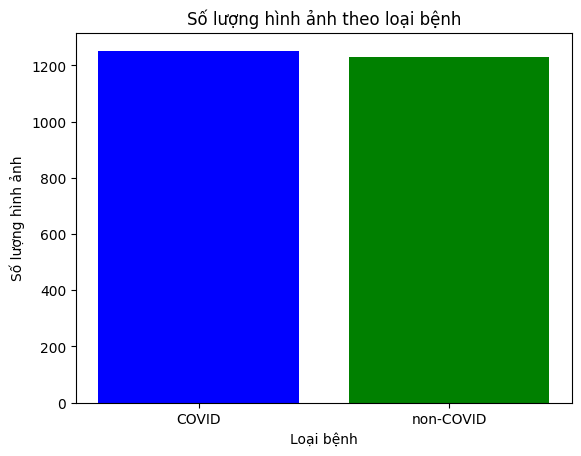

In [ ]:

# Tạo một từ điển để lưu số lượng hình ảnh cho mỗi loại bệnh
image_count = {disease: 0 for disease in disease_types}

# Duyệt qua các thư mục con của train_dir (mỗi thư mục con tương ứng với một loại bệnh)
for disease in disease_types:
    disease_path = os.path.join(train_dir, disease)

    # Kiểm tra xem thư mục tồn tại hay không
    if os.path.exists(disease_path):
        # Đếm số lượng tệp hình ảnh trong thư mục
        image_count[disease] = len(os.listdir(disease_path))
    else:
        print(f"Thư mục '{disease}' không tồn tại.")

# Hiển thị thông tin thống kê
for disease, count in image_count.items():
    print(f"Số lượng hình ảnh cho {disease}: {count}")

# Vẽ biểu đồ histogram
labels = list(image_count.keys())
counts = list(image_count.values())

plt.bar(labels, counts, color=['blue', 'green'])
plt.xlabel('Loại bệnh')
plt.ylabel('Số lượng hình ảnh')
plt.title('Số lượng hình ảnh theo loại bệnh')
plt.show()

In [ ]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (126).png,0,COVID
1,COVID/Covid (193).png,0,COVID
2,COVID/Covid (133).png,0,COVID
3,COVID/Covid (191).png,0,COVID
4,COVID/Covid (174).png,0,COVID


In [ ]:
#Sắp xếp ngẫu nhiên thứ tự đào tạo
SEED = 42
train = train.sample(frac=1, random_state=SEED)
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,COVID/Covid (432).png,0,COVID
1,COVID/Covid (542).png,0,COVID
2,non-COVID/Non-Covid (620).png,1,non-COVID
3,non-COVID/Non-Covid (520).png,1,non-COVID
4,COVID/Covid (713).png,0,COVID


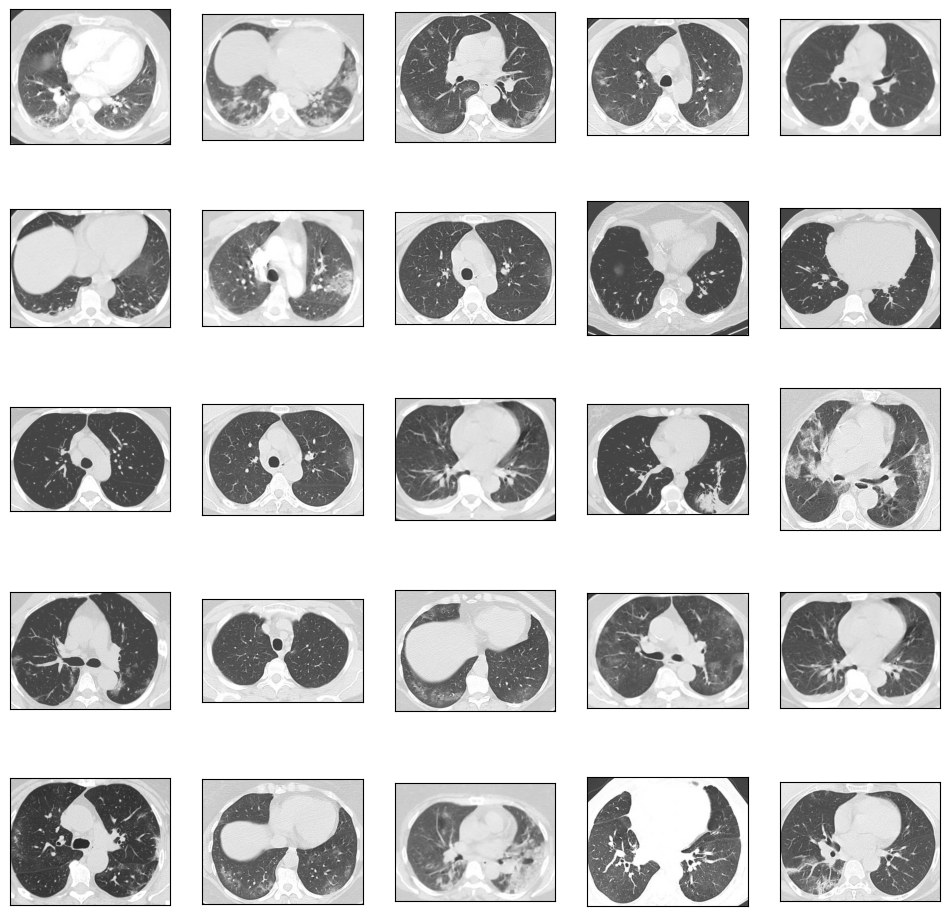

In [ ]:
#Hiển thị hình ảnh về COVID
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12,12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
#Hiển thị n hình ảnh đầu tiên của lớp từ tập huấn luyện
plot_defects('COVID', 5, 5)

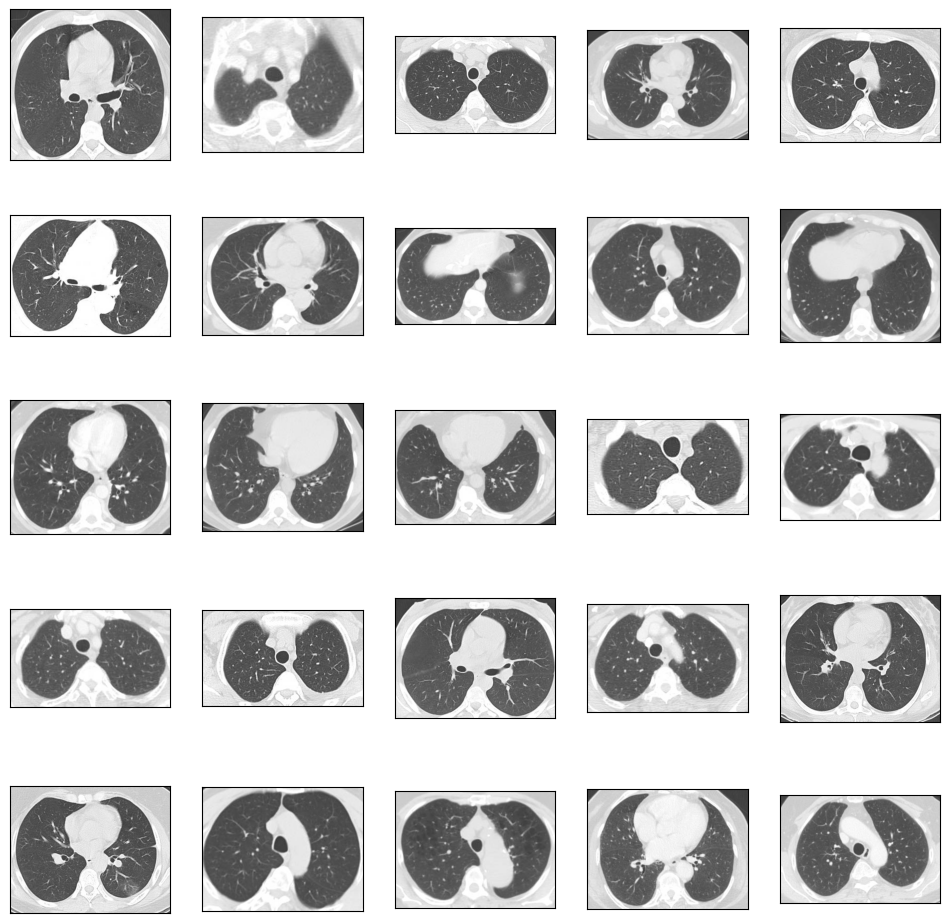

In [ ]:
#Hiển thị hình ảnh về NonCovid
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Hiển thị n hình ảnh đầu tiên của lớp từ tập huấn luyện
plot_defects('non-COVID', 5, 5)

In [ ]:
#Đọc và thay đổi kích thước hình ảnh
IMAGE_SIZE = 128
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [ ]:
#chuyen anh mau thanh anh xam
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))  # Kích thước cuối cùng là 1 để đại diện cho grayscale

for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Chuyển đổi ảnh màu thành grayscale
        resized_image = resize_image(gray_image, (IMAGE_SIZE, IMAGE_SIZE))
        X_train[i, :, :, 0] = resized_image  # Gán ảnh grayscale vào ma trận X_train

#Chuẩn hóa dữ liệu
X_Train = X_train / 255. #ma trận X_train được chia cho 255 để đưa giá trị pixel từ khoảng 0-255 về khoảng 0-1,giúp đảm bảo rằng giá trị đầu vào có cùng phạm vi và phân bố tương tự, giúp mô hình học tốt hơn và ổn định hơn.
print('Train Shape: {}'.format(X_Train.shape))

2481it [10:19,  4.00it/s]

Train Shape: (2481, 128, 128, 1)


In [ ]:
#Chuyển đổi nhãn thành phân loại
#Sau khi convert, dữ liệu label sẽ được mã hóa thành mảng số 0,1 tương ứng với từng lớp.
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)
print(Y_train.shape)

(2481, 2)


In [ ]:
#Train Test Splitting
BATCH_SIZE = 256
# Split the train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

In [ ]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_val.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_val.shape)

X_train: (1984, 128, 128, 1)
X_val: (497, 128, 128, 1)
Y_train: (1984, 2)
Y_val: (497, 2)


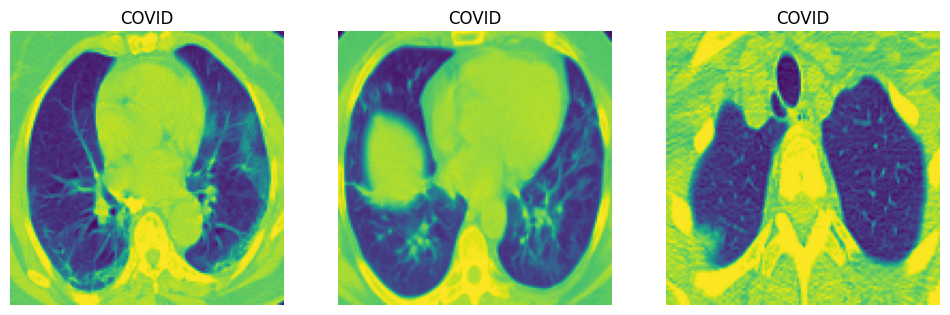

In [ ]:
#Hình ảnh sau khi chuyển dổi kích thước 128,128, anh he 1
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [ ]:
EPOCHS = 200
SIZE=128
N_ch=1

In [ ]:
from tensorflow.keras.optimizers import legacy as tfk_legacy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)

   # model
    model = Model(input,output)
    optimizer = tfk_legacy.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=0.1, #tranh viec chia cho 0 đảm bảo tính ổn định và hiệu quả của quá trình huấn luyện
            decay=0.0001
        )
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    return model


In [ ]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
#Callback để lưu phiên bản tốt nhất của mô hình
checkpoint = ModelCheckpoint('Densenet121_best.h5', verbose=1, save_best_only=True)
#Dừng huấn luyện khi không cải thiện
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True) #patience=50 quá trình huấn luyện sẽ dừng nếu mất mát trên tập validation không giảm trong 10 epoch liên tiếp.
    #estore_best_weights=True, mô hình sẽ được khôi phục lại trạng thái tốt nhất (có mất mát nhỏ nhất trên tập validation) trước khi dừng quá trình huấn luyện.
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(
                        rotation_range=360, # cho phép quay ảnh ngẫu nhiên trong khoảng từ 0 đến 360 độ.
                        width_shift_range=0.2, #  cho phép dịch chuyển ảnh ngang từ -0.2 lần chiều rộng ảnh đến 0.2 lần chiều rộng ảnh.
                        height_shift_range=0.2, # cho phép dịch chuyển ảnh dọc từ -0.2 lần chiều cao ảnh đến 0.2 lần chiều cao ảnh
                        zoom_range=0.2, # Phạm vi thu phóng ngẫu nhiên -20 đến 20 độ
                        shear_range=0.2,  # Góc cắt từ -20 đến 20 độ
                        horizontal_flip=True, # Lật ngẫu nhiên đầu vào theo chiều ngang
                        vertical_flip=True) # Lật ngẫu nhiên đầu vào theo chiều dọc
datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
# Bắt đầu đếm thời gian huấn luyện
import datetime
start = datetime.datetime.now()
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
                 callbacks=[annealer, checkpoint, early_stopping],
               validation_data=(X_val, Y_val))
# Kết thúc đếm thời gian huấn luyện
end = datetime.datetime.now()
print ('* total training time:', str(end-start))

29084464/29084464 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       30        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                               

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 - 57s - loss: 1.2045 - accuracy: 0.5249 - val_loss: 0.9757 - val_accuracy: 0.5513 - lr: 0.0010 - 57s/epoch - 8s/step
Epoch 2/200

Epoch 2: val_loss improved from 0.97572 to 0.92886, saving model to Densenet121_best.h5
7/7 - 9s - loss: 1.2294 - accuracy: 0.5255 - val_loss: 0.9289 - val_accuracy: 0.5513 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 3/200

Epoch 3: val_loss improved from 0.92886 to 0.88461, saving model to Densenet121_best.h5
7/7 - 9s - loss: 1.1392 - accuracy: 0.5446 - val_loss: 0.8846 - val_accuracy: 0.5473 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 4/200

Epoch 4: val_loss improved from 0.88461 to 0.83909, saving model to Densenet121_best.h5
7/7 - 9s - loss: 1.1398 - accuracy: 0.5579 - val_loss: 0.8391 - val_accuracy: 0.5433 - lr: 0.0010 - 9s/epoch - 1s/step
Epoch 5/200

Epoch 5: val_loss improved from 0.83909 to 0.79782, saving model to Densenet121_best.h5
7/7 - 9s - loss: 1.1275 - accuracy: 0.5642 - val_loss: 0.7978 - val_accuracy: 0.5433 - lr: 0.0010 - 9s/epoch - 1s/step

In [ ]:
# Lưu trạng thái hiện tại của mô hình
model.save('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/densenet121/Densenet121_1.h5')

In [ ]:
from keras.models import load_model
# Load model
# model = load_model('/content/drive/MyDrive/Colab Notebooks/chuyende_cntt/covid_19/model_kq/DenseNet121_L1.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 1s 39ms/step - loss: 0.2047 - accuracy: 0.9276
Final Loss: 0.2047474980354309, Final Accuracy: 0.9275653958320618


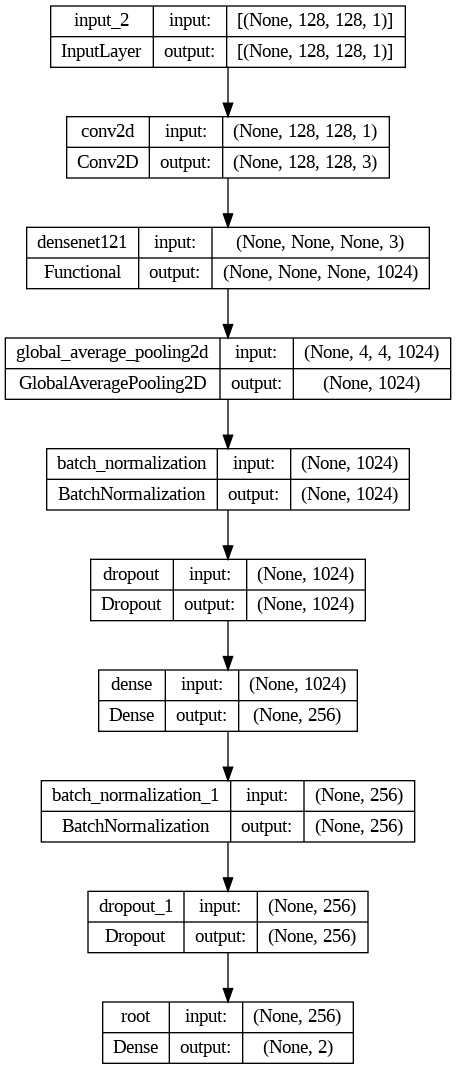

In [ ]:
# #MÔ HÌNH HUẤN LUYỆN
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='DenseNet121.png', show_shapes=True,show_layer_names=True)
# Image(filename='convnet.png')

In [ ]:
#Accuracy and Loss Curve

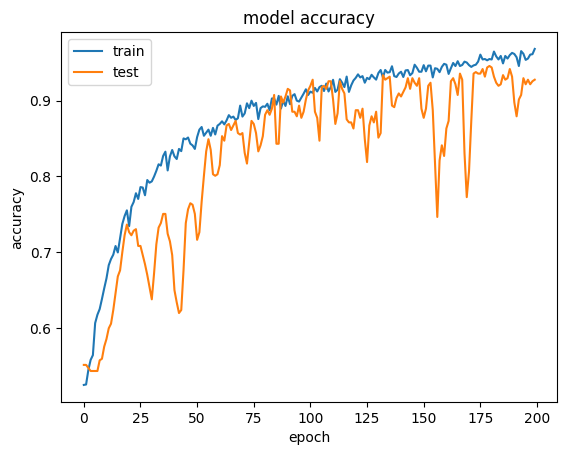

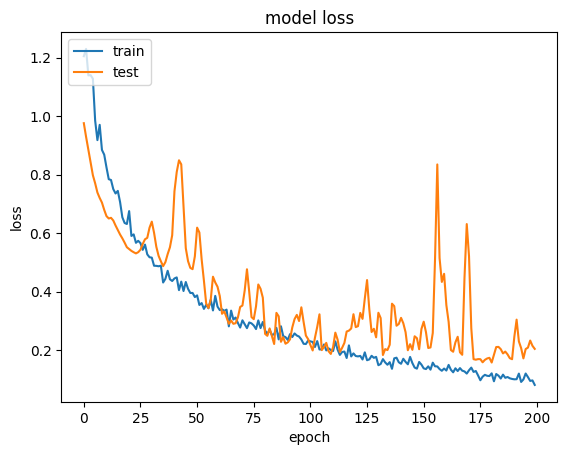

In [ ]:
# accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

16/16 [==============================] - 1s 36ms/step
True negative (TN): 0.5050
False negative (FN): 0.0262
True positive (TP): 0.4225
False positive (FP): 0.0463
Accuracy : 0.9276 
Precision : 0.9013 
Recall: 0.9417
F1-score: 0.9211


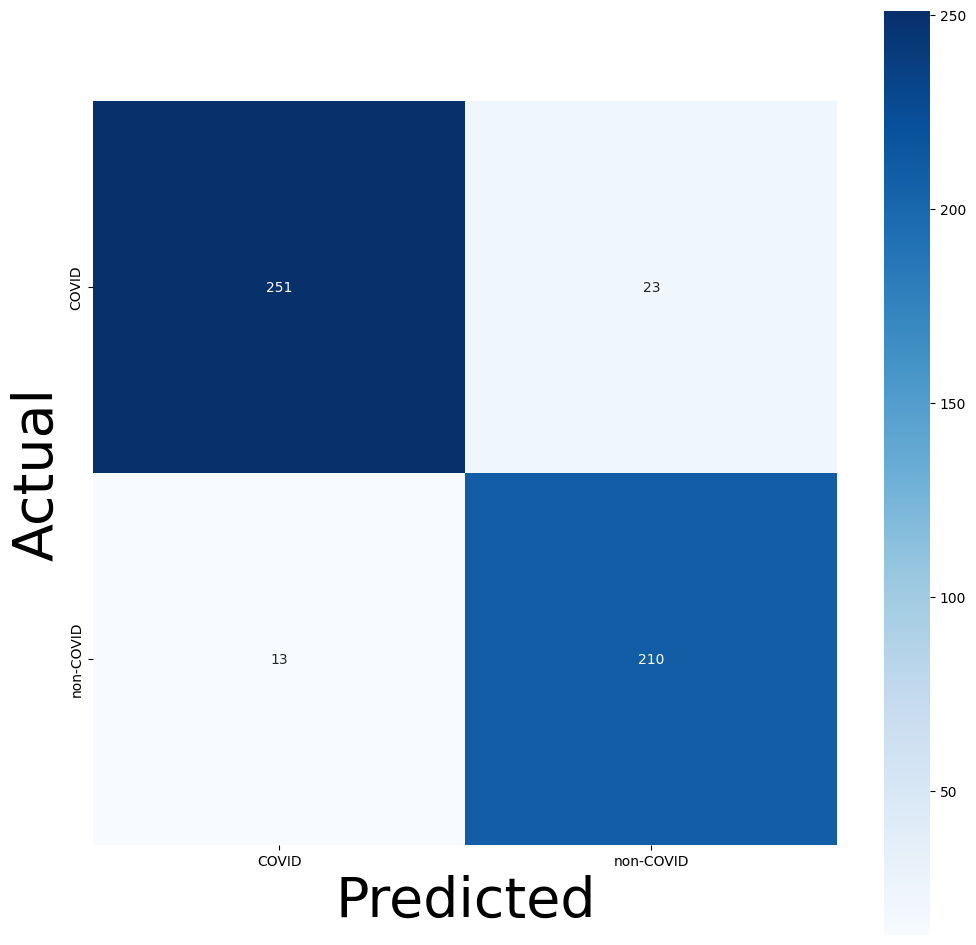

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

#Giả sử Y_pred và Y_true lần lượt là nhãn được dự đoán và nhãn đúng
# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(Y_true, Y_pred)

# Lấy các giá trị TP, FN, FP, TN từ ma trận nhầm lẫn
TN = cm[0][0]
#print(TN)
FN = cm[1][0]
#print(FN)
TP = cm[1][1]
#print(TP)
FP = cm[0][1]
#print(FP)

# Tính toán TN (True Negative) là số lượng mẫu được dự đoán ấm tính và thực tế cũng là âm tính
true_negative = cm[0, 0] / len(Y_pred)
print('True negative (TN): %.4f' % true_negative)

# Tính toán FN (False Negative) Số lượng mẫu được dự đoán sai là âm tính nhưng thực tế là dương tính.
false_negative = cm[1, 0] / len(Y_pred)
print('False negative (FN): %.4f' % false_negative)
# Tính TP (True Positive): Số lượng các mẫu được dự đoán đúng là thuộc lớp dương tính thực tế cũng dương tính
true_positive = cm[1, 1] / len(Y_pred)
print('True positive (TP): %.4f' % true_positive)

# Tính FP (False Positive): Số lượng các mẫu được dự đoán sai là thuộc lớp dương tính nhưng thực tế thuộc lớp âm tính.
false_positive = cm[0, 1] / len(Y_pred)
print('False positive (FP): %.4f' % false_positive)

# Tính toán độ chính xác tổng thể accuracy, tỷ lệ dự đoán đúng trên tổng số mẫu.
          # Công thức:  ACC = (TP+TN)/(TP+FP+FN+TN) accuracy=(số lượng dự đoán đúng) / (tổng số mẫu)
accuracy = accuracy_score(Y_true, Y_pred)
print('Accuracy : %.4f ' % accuracy)

# Tính precision (Độ chính xác dương tính), tỷ lệ của các dự đoán dương tính đúng trên tổng số dự đoán dương tính
          #Công thức:P = TP / (TP + FP)
precision = precision_score(Y_true, Y_pred)
print('Precision : %.4f '  % precision)

#  recall (Độ phủ) Tính tỷ lệ các dự đoán dương tính đúng trên tổng số thực tế dương tính (bao gồm cả true positive và false negative)
    #Công thức: TPR = TP/(TP+FN)
recall = recall_score(Y_true, Y_pred)
print('Recall: %.4f' % recall)

#  F1-score Kết hợp giữa precision và recall để đánh giá hiệu suất dự đoán. F1-score là trung bình điều hòa của precision và recall.
#F1-score càng cao, tức là mô hình có hiệu suất cân bằng giữa việc dự đoán đúng các mẫu dương tính và đảm bảo không bỏ sót quá nhiều mẫu dương tính.
    #Công thức: 2 * (precision * recall) / (precision + recall).    #f1_score = cm[1, 1] / (cm[1, 1] + ((cm[0, 1] + cm[1, 0]) / 2))
f1 = f1_score(Y_true, Y_pred)


print('F1-score: %.4f' % f1)

# Plot confusion matrix
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Blues, annot=True,  fmt='d', square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)
plt.show()


In [ ]:
# '''FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
# FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
# TP = np.diag(confusion_matrix)
# TN = confusion_matrix.values.sum() - (FP + FN + TP)'''

# TN = cm[0][0]
# #print(TN)
# FN = cm[1][0]
# #print(FN)
# TP = cm[1][1]
# #print(TP)
# FP = cm[0][1]
# #print(FP)

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# print(TPR)
# # Specificity or true negative rate
# TNR = TN/(TN+FP)
# print(TNR)
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# print(FNR)
# # False discovery rate
# FDR = FP/(TP+FP)

# # Overall accuracy
# ACC = (TP+TN)/(TP+FP+FN+TN)
# print(ACC)

1/1 [==============================] - 11s 11s/step
[0.98742825 0.01257171]
Prediction: Covid-19


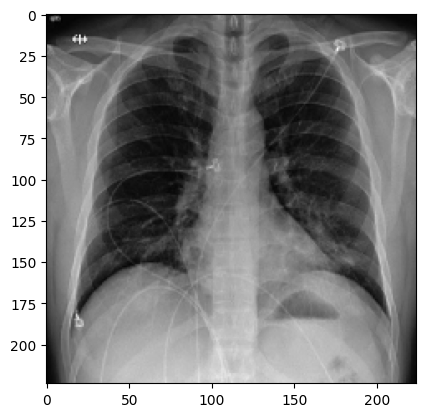

Accuracy: 98.74282479286194 %


In [1]:
from skimage import io
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load model
model = load_model('/content/drive/MyDrive/Colab Notebooks/chuyendecntt/densenet121/Densenet121_1.h5')

# Lấy ảnh và chuẩn bị dữ liệu cho model dự đoán
path = '/content/drive/MyDrive/Colab Notebooks/chuyendecntt/TEST/xquang_test.jpg'
img = image.load_img(path, color_mode='grayscale', target_size=(128,128))
show_img = image.load_img(path, color_mode='grayscale', target_size=(224, 224))
disease_class = ['Covid-19', 'Non Covid-19']
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x /= 255

# Dự đoán
custom = model.predict(x)

# In kết quả dự đoán
print(custom[0])
a = custom[0]
ind = np.argmax(a)
print('Prediction:', disease_class[ind])

# Hiển thị ảnh và tỷ lệ chính xác
# plt.imshow(show_img)
plt.imshow(show_img, cmap='gray')
plt.show()
print('Accuracy:', custom[0][ind] * 100, '%')